In [13]:
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo
from scipy.stats import bartlett
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pingouin as pg
import seaborn as sns

In [14]:
data_path = "data_cleaned_feature_31.csv"
data = pd.read_csv(data_path)
print(data.columns)
data.shape

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'channel_id', 'video_title',
       'video_description', 'video_default_thumbnail', 'video_category_id',
       'video_tags', 'video_duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'video_view_count', 'video_like_count',
       'video_comment_count', 'channel_title', 'channel_description',
       'channel_custom_url', 'channel_published_at', 'channel_country',
       'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds'],
      dtype='object')


(650048, 31)

In [ ]:

data.shape

(357413, 30)

In [16]:
data.select_dtypes(include=['int64', 'float64'])

,video_view_count,video_like_count,video_comment_count,channel_view_count,channel_subscriber_count,channel_video_count,engagement_rate,video_duration_seconds
0,20535235.0,2042255.0,152933.0,464615150,11600000,43,0.106899,148.0
1,853167.0,101155.0,10541.0,114331110,1380000,314,0.130919,2604.0
2,1730189.0,67522.0,2869.0,19991522,40600,56,0.040684,132.0
3,1073421.0,35534.0,1263.0,655373060,4710000,1746,0.034280,15.0
4,56032799.0,1058450.0,44767.0,269373477007,276000000,21864,0.019689,231.0
...,...,...,...,...,...,...,...,...
650042,280194.0,3711.0,926.0,212304779,866000,15420,0.016549,188.0
650044,920369.0,34452.0,2826.0,640672504,3120000,494,0.040503,663.0
650045,1269386.0,46713.0,7124.0,817972117,2960000,925,0.042412,130.0
650046,2037696.0,79148.0,2618.0,2823553551,7320000,164,0.040127,172.0


In [17]:
duplicate_summary = {
    "Total Rows": len(data),
    "Duplicate Rows (Entire Row)": data.duplicated().sum(),
    "Duplicate Video IDs": data.duplicated(subset=['video_id']).sum()
}
duplicate_summary 

{'Total Rows': 357413,
 'Duplicate Rows (Entire Row)': 0,
 'Duplicate Video IDs': 334079}

In [18]:
data.shape

(357413, 30)

In [19]:
data = data.drop_duplicates(subset=['video_id'])
data.shape

(23334, 30)

In [20]:
def time_to_seconds(time_str):
    days, time_part = time_str.split(" days ")
    days = int(days)
    h, m, s = map(int, time_part.split(":"))
    total_seconds = days * 86400 + h * 3600 + m * 60 + s
    return total_seconds

data['time_to_trend_difference_seconds'] = data['time_difference'].apply(time_to_seconds)
data['likes_per_view'] = data['video_like_count'] / data['video_view_count']
data['comments_per_view'] = data['video_comment_count'] / data['video_view_count']
data['is_weekend'] = pd.to_datetime(data['video_published_at']).dt.weekday >= 5

In [21]:
data['is_trending'] = data['time_difference'].apply(
    lambda x: 1 if int(x.split(" ")[0]) <= 1 else 0 
)
data.is_trending.value_counts() ## checking how fast videos are trending

is_trending
1    16498
0     6836
Name: count, dtype: int64

In [22]:
# do split (" ") and take the first element

data["time_difference_days"] = data["time_difference"].apply(lambda x: int(x.split(" ")[0]))
data["time_difference_days"]

0         0
1         0
2         2
3        -1
4         2
         ..
649469    0
649477    1
649487    0
649530    0
649532    0
Name: time_difference_days, Length: 23334, dtype: int64

In [23]:
# use data['video_published_at'] to make a column if morning, afternoon, evening, night
data['video_published_at'] = pd.to_datetime(data['video_published_at'])
data['published_hour'] = data['video_published_at'].dt.hour
data['published_morning'] = data['published_hour'].between(6, 12)
data['published_afternoon'] = data['published_hour'].between(12, 18)
data['published_evening'] = data['published_hour'].between(18, 24)
data['published_night'] = data['published_hour'].between(0, 6)

In [ ]:
data['channel_published_at'] = pd.to_datetime(data['channel_published_at'], errors='coerce').dt.tz_localize(None)
data['video_published_at'] = pd.to_datetime(data['video_published_at'], errors='coerce').dt.tz_localize(None)
data['channel_video_channel_publish_difference'] = (data['video_published_at'] - data['channel_published_at']).dt.days
data['channel_video_channel_publish_difference']
data['channel_video_channel_publish_difference'] = data['channel_video_channel_publish_difference'].fillna(data['channel_video_channel_publish_difference'].mean()) # di ko na alam kung tama to

In [26]:
data['is_trending'].value_counts()

is_trending
1    16498
0     6836
Name: count, dtype: int64

In [27]:
data['is_weekend'].value_counts()

is_weekend
False    16493
True      6841
Name: count, dtype: int64

In [28]:
data.columns

Index(['video_id', 'video_published_at', 'video_trending__date', 'channel_id',
       'video_title', 'video_description', 'video_default_thumbnail',
       'video_category_id', 'video_tags', 'video_duration', 'video_dimension',
       'video_definition', 'video_licensed_content', 'video_view_count',
       'video_like_count', 'video_comment_count', 'channel_title',
       'channel_description', 'channel_custom_url', 'channel_published_at',
       'channel_country', 'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'engagement_rate', 'time_difference', 'video_duration_seconds',
       'time_to_trend_difference_seconds', 'likes_per_view',
       'comments_per_view', 'is_weekend', 'is_trending',
       'time_difference_days', 'published_hour', 'published_morning',
       'published_afternoon', 'published_evening', 'published_night',
       'channel_vid

In [29]:
categorical_features = [
    'video_category_id', 'is_weekend',
    'video_definition', 'video_dimension', 'video_licensed_content',
    'channel_country', 'channel_have_hidden_subscribers', 'published_morning', 'published_afternoon', 'published_evening', 'published_night'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [30]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
#X_text = data[embedded_text_columns]?
y = data['engagement_rate']

In [31]:
# from sklearn.ensemble import IsolationForest
# isolation_forest = IsolationForest(contamination=0.10, random_state=42) 
# outliers = isolation_forest.fit_predict(X_numerical)

# data_cleaned = data[outliers != -1]
# data_cleaned.shape

In [32]:
X_categorical = data[categorical_features]
X_numerical = data[numerical_features]
y = data['engagement_rate']

In [33]:
y.isnull().sum()

0

In [34]:
import numpy as np
#X = np.hstack((X_numerical, X_categorical))
X = pd.concat((X_numerical, X_categorical),axis=1)
X.shape

(23334, 14)

In [35]:
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from feature_engine.pipeline import Pipeline

pipeline = Pipeline([
    ("drop_constant_features", DropConstantFeatures(tol=0.98)),
    ("drop_duplicate_features", DropDuplicateFeatures()),
    ("drop_correlated_features", DropCorrelatedFeatures(method='pearson', threshold=0.85))
])

X_final = pipeline.fit_transform(X)

In [36]:
# check difference of columns between X and X_final
set(X.columns) - set(X_final.columns)

{'channel_have_hidden_subscribers', 'video_definition', 'video_dimension'}

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=42)

In [38]:
y_train

579       0.032851
115122    0.035788
345074    0.009000
521352    0.067765
229138    0.019506
            ...   
256234    0.026503
595759    0.009878
38823     0.053260
2918      0.090691
392768    0.025730
Name: engagement_rate, Length: 16333, dtype: float64

In [39]:
categorical_features = [
    'video_category_id', 'is_weekend' ,'video_licensed_content',
    'channel_country', 'published_morning', 'published_afternoon', 'published_evening', 'published_night'
]
numerical_features = [
    'video_duration_seconds', 'channel_video_count', 'channel_video_channel_publish_difference'
]

In [41]:
X_train_categorical = X_train[categorical_features]
X_test_categorical = X_test[categorical_features]

X_train_numerical = X_train[numerical_features]
X_test_numerical = X_test[numerical_features]

In [42]:
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import MeanEncoder

encoder = DecisionTreeEncoder(random_state=42)
X_train_encode = encoder.fit_transform(X_train_categorical, y_train)
X_test_encode = encoder.transform(X_test_categorical)

In [43]:
# from feature_engine.transformation import LogTransformer

# log_transformer = LogTransformer(variables=numerical_features)

# X_train_log = log_transformer.fit_transform(X_train_numerical)
# X_test_log = log_transformer.transform(X_test_numerical) # di naman gumana hahahaha

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numerical)
X_test_scaled = scaler.transform(X_test_numerical)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

In [45]:
X_train = np.hstack((X_train_encode, X_train_scaled))
X_test = np.hstack((X_test_encode, X_test_scaled))

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train, y_train)

y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train R2: {train_r2}")
print(f"Test R2: {test_r2}")

Train MSE: 0.00011438448278173227
Test MSE: 0.0009008612936570303
Train R2: 0.9074153086797286
Test R2: 0.30664635015805697


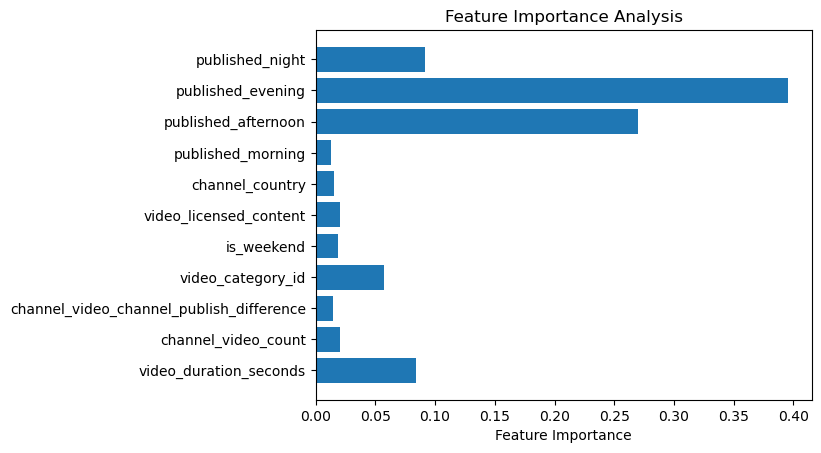

In [47]:
import matplotlib.pyplot as plt
feature_importances = regressor.feature_importances_
feature_names = list(X_train_numerical.columns) + list(X_train_categorical.columns)
plt.barh(feature_names, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Analysis')
plt.show()

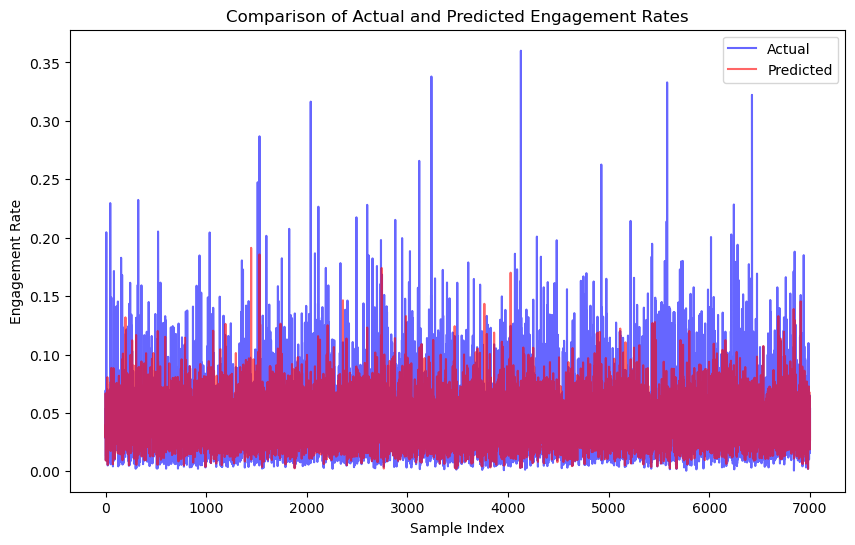

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='blue', alpha=0.6)
plt.plot(y_pred_test, label='Predicted', color='red', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Engagement Rate')
plt.title('Comparison of Actual and Predicted Engagement Rates')
plt.legend()
plt.show()